In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
import random
import math, statistics
import numpy as np
from scipy.spatial import distance

In [2]:
class CaseAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, initial_wealth=10):
        super().__init__(unique_id, model)
        self.wealth = initial_wealth
        self.alt_wealth_calculation=0
        self.original_wealth=self.wealth
        self.memory = []
        self.action = 0
        self.result=0
        self.cases = []
        self.deflator_cases = []
        self.circumstances = []
        self.action_set=[0.25, 0.5, 0.75]
        
    def get_circumstance(self):
        if len(model.realized_interest_rate_list) <=2:
            p_2 = random.choice(range(0,1))
            p_1 = 1                  
            new_circumstance = (p_2-p_1)/p_1
        else:
            new_circumstance =  (model.realized_interest_rate_list[-1]- model.realized_interest_rate_list[-2])/model.realized_interest_rate_list[-2]
        return new_circumstance
        print( "new circumstance is", new_circumstance, ".")
        
    def get_wealth(self):
        wealth = self.wealth
        return wealth
    
    def choose_action(self):
        if not self.cases:
            choice = random.choice(self.action_set)
            
        else:
            best_choice = self.evaluate_actions()    
            choice=random.choice(best_choice)
        return choice    
         
    
    def evaluate_actions(self):                  #evaluate all the actions and choose the one which has highest CBU
        cbu_list = list()
        for action in self.action_set:
            all_action_cbu = []
            new = np.array([action,self.get_circumstance()])
                
           
            for case in self.deflator_cases: #<--- looping through memory for each action, accumulate data in all_action_cbu    
                old =np.array([case["action"], case["circumstance"]])
                if abs(action-case["action"]) > model.B/2: #<--- do not consider this case, out of bandwidth
                    pass # you don't need to do anything here
                    
                else: #<--- consider this case and add to all_action_cbu
                    similarity =1/math.exp(distance.euclidean(new,old))
                    single_case_cbu = similarity*(case["result"] - model.H)
                    all_action_cbu.append(single_case_cbu)
             
            # Now, we have gone through all memory, and evaluate it for this action
            if len(all_action_cbu) == 0 : # I have found NO relevant cases in memory (TODO: CHECK CODE)
                cbu = 0
            else: # I have found at least one relevant case
                cbu = sum(all_action_cbu)

            act_value = {"action":action, "value":cbu}
            cbu_list.append(act_value)
            # now we have act_value for this action
   
        best_value = max(cbu_list, key=(lambda x: x["value"]))
        #print("best_value is ",best_value)
        best_choices= []
    
      

        for act_value in cbu_list:
            if act_value["value"] == best_value["value"]:
                best_choices.append(act_value["action"])
                
        return best_choices
        print(best_choices,".")            
    
    def get_flow_utility(self):
        consumption = self.wealth*self.action
        flow_utility = math.log(consumption)   #calculate each agent's payoff
        return flow_utility
        
    #def get_continuation_utility(self):
    
    def update_case(self):
        values = i.cases.values()
        values_list = list(values)
        i.cases[k]["result"]=i.cases
        return cases
    
    def print(self):
        print("agent: ", self.unique_id, " wealth: ", self.wealth," original_wealth: ", self.original_wealth, 
              " alt wealth: ", self.alt_wealth_calculation , "ratio:", self.original_wealth / self.alt_wealth_calculation )
        

In [3]:
class CaseModel(Model):
    """A model with some number of agents."""
    def __init__(self, N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=.5, K0=None, initial_wealth=10, use_alt_wealth=False
                 , verbose=False):#(50,0.1,10,0.90,1,0.33,None,0.5)
        self.num_agents = N
        # Create agents
        self.schedule = RandomActivation(self)
        self.actions=[]
        self.all_capital = []
        self.all_consumption = []
        if K0 is not None:
            self.total_K = K0
        else:
            self.total_K = N * initial_wealth
        self.consumption_list = []
        self.capital_list = []
        self.total_C = 0
        self.results=[]
        self.wealths=[]
        
        self.verbose=verbose
        
        self.use_alt_wealth = use_alt_wealth
        
        self.realized_interest_rate = 0
        self.realized_interest_rate_list = []
        self.real_wage = 0
        self.real_wage_list = []
        self.total_output=0
        self.output_list = []
        self.agents=[] #ADP: have an agents vector directly in Model.
        self.tick=0    #ADP: keep track of time.
        self.H = H
        self.B = Bandwidth
        self.beta = beta
        self.action_set=[0.25, 0.5, 0.75]
        self.z = z
        self.alpha = alpha
        self.deflator=deflator
        self.delta=delta
          # Create agents
        for i in range(self.num_agents):
            a = CaseAgent(i, self, initial_wealth)
            self.schedule.add(a)
            self.agents.append(a)
        self.datacollector = DataCollector(
            model_reporters={"interest_rate": "realized_interest_rate",
                             "real_wage":"real_wage",
                            'GDP':"last_output", #'GDP':"total_output",
                             "capital":"total_K",
                            "consumption":"total_C"},
            agent_reporters={"Wealth": "wealth", "Result": "result", "Action": "action", "Cases":"cases"})
        
    def reset(self):
        self.actions = []
        self.all_capital=[]
        self.all_consumption=[]
        self.results = []
        
    def calculate_price(self):
        total_K=sum(self.all_capital)
        realized_interest_rate =self.z*self.alpha*(total_K**(self.alpha-1))
        
        if self.use_alt_wealth:
            realized_interest_rate = self.total_output / self.total_K - 1
        
        return realized_interest_rate
    
    def calculate_wage(self):
        total_K=sum(self.all_capital)
        real_wage =self.z*(1-self.alpha)*(total_K**self.alpha)
        return real_wage
    
    def get_output(self):
        total_K=sum(self.all_capital)
        total_output =self.z*(total_K**(self.alpha))
        return total_output
    
    def get_consumption(self):
        total_C=sum(self.all_consumption)
        return total_C
    
    def get_capital(self):
        total_K=sum(self.all_capital)
        return total_K
    
    def update_H(self):
        self.H = (self.H)*self.beta
        return self.H
    
    def initialize(self):
        
        for i in self.agents:
            i.action = random.choice(self.action_set)
            self.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            self.all_capital.append(i.current_capital)
        #print( "actions:", self.actions, ".") 
        #print( "all capital", self.all_capital, ".") 
        
    def step(self):
        '''Advance the model by one step.'''
        
        
        #self.schedule.step()
        
        
        self.reset() # this sets up the turn
        self.tick += 1 # ADP: iterate time.
        #previous_price = self.calculate_price()
        
        #save lags
        self.last_total_K = self.total_K
        self.last_output = self.total_output
        
        for i in self.agents:
            # loop where agents choose
            
            self.H = self.update_H()
            i.new_circumstance = i.get_circumstance()  #observe new circumstance
            
            #i.wealth = i.get_wealth()
            #print( "new circumstance:", i.new_circumstance, ".") 
            
            i.action = i.choose_action()
            #print( "choices:", i.evaluate_actions, ".") 
            #agents make predictions for each round "action"
           
            self.actions.append(i.action)
            i.current_capital = i.wealth*(1-i.action)
            i.current_consumption = i.wealth*i.action
            
            self.all_capital.append(i.current_capital)
            self.all_consumption.append(i.current_consumption)
            
        
        #print("all past prices are:", self.realized_interest_rate_list)
        
        
        #
        self.realized_interest_rate = self.calculate_price() # must be based on current action
        
        
        self.real_wage = self.calculate_wage()        
        self.realized_interest_rate_list.append(self.realized_interest_rate)
        self.real_wage_list.append(self.real_wage)
        self.total_output = self.get_output()  
        self.output_list.append(self.total_output)
        self.total_C = self.get_consumption()
        self.total_K = self.get_capital()
        self.consumption_list.append(self.total_C)
        self.capital_list.append(self.total_K)
        if self.verbose:
            print( "price:", self.realized_interest_rate, ".") #model calculate the market price  "circumstance"

        
        
        for i in self.agents: 
            # loop where they get their payoffs
            
            i.result = i.get_flow_utility()                 #agents get their payoff for each round  "result"
            self.results.append(i.result)
            
            i.new_case = {"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.cases.append(i.new_case)
          
            i.deflator_case={"action": i.action,
                        "result": i.result,
                        "circumstance": i.get_circumstance()}
            i.deflator_cases.append(i.deflator_case)
            for index in range(len(i.deflator_cases)):
                length=len(i.deflator_cases)
                i.deflator_cases[index]["result"]=i.deflator_cases[index]["result"]+self.delta**(length-index)*i.result
                
            #i.update_case()
            #print(i.cases[:3]) 
      
           
            #i.actions_chosen.append(i.prediction)
            i.wealth = i.current_capital*(1+self.realized_interest_rate)            #next period goods
            i.original_wealth=i.wealth
            
            i.alt_wealth_calculation= self.total_output * ( i.current_capital / self.total_K ) #<--- actual return
            
                # ( i.current_capital / self.total_K ) = my fraction of the capital I own.
                # total_K = not based on current output. 
            
            if self.use_alt_wealth:
                i.wealth=i.alt_wealth_calculation
            
        self.datacollector.collect(self)    
       
        
        if self.verbose:
            print( "Time:", self.tick, ".") 
        #print( "Model_choices:", self.actions, ".")  
        #print( "Model_results:", self.results, ".")
      
       
         
    def print(self): 
        # ADP: Give every object a "print" function.
     
        print( "my__prediction", self.actions, ".")
        print( "realized_price", self.realized_interest_rate, ".")
        
        for i in self.agents:
            i.print()

In [4]:
model = CaseModel(N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=.5,use_alt_wealth=True)

model.initialize()
for i in range(50):
    model.step()    

    #model.print()
import matplotlib.pyplot as plt



# For jupyter notebook add the following line:
%matplotlib inline
all_data = model.datacollector.get_model_vars_dataframe()


In [5]:
all_data[1:2]

,interest_rate,real_wage,GDP,capital,consumption
1,-0.974751,1.005743,6.122868,3.424387,2.69848


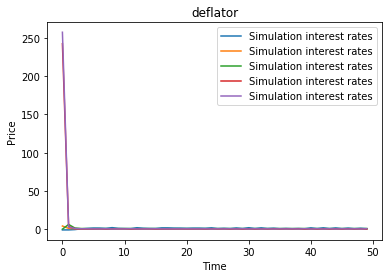

In [6]:
plt.figure()

plt.plot(all_data,label="Simulation interest rates")


plt.xlabel("Time")
plt.ylabel("Price")
plt.title("deflator")
#
plt.legend()

#model.datacollector.get_agent_vars_dataframe()

#plt.figure()
plt.savefig('deflator.png')

In [7]:
all_data.columns

Index(['interest_rate', 'real_wage', 'GDP', 'capital', 'consumption'], dtype='object')

In [8]:
def figfromdat(dat=None,name="default"):
    plt.figure()

    somedata=dat[10:50]
    plt.plot(somedata, label=somedata.columns)


    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("deflator")
    #
    plt.legend()

    #model.datacollector.get_agent_vars_dataframe()

    #plt.figure()
    plt.savefig(name+'deflator.png')


In [9]:
modelNoDefl = CaseModel(N=50, Bandwidth=0.1, H=10, beta=.9,z=1,alpha=.33,deflator=None,delta=0,use_alt_wealth=True)

modelNoDefl.initialize()
for i in range(50):
    modelNoDefl.step()    
    
data_NoDefl = modelNoDefl.datacollector.get_model_vars_dataframe()

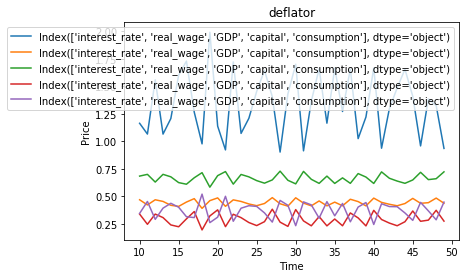

In [10]:
figfromdat(dat=data_NoDefl,name="NoDefl")

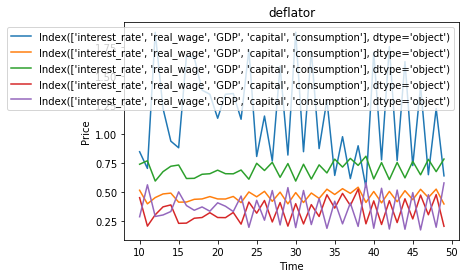

In [11]:
figfromdat(dat=all_data,name="Defl")

In [12]:
model.print()

my__prediction [0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75] .
realized_price 0.6392080591811715 .
agent:  0  wealth:  4.933003487215904e-05  original_wealth:  2.799492408669978e-05  alt wealth:  4.933003487215904e-05 ratio: 0.5675026210553036
agent:  1  wealth:  0.0044951994277254905  original_wealth:  0.0025510374574005167  alt wealth:  0.0044951994277254905 ratio: 0.5675026210553036
agent:  2  wealth:  0.026971196566352957  original_wealth:  0.015306224744403105  alt wealth:  0.026971196566352957 ratio: 0.5675026210553035
agent:  3  wealth:  0.0044951994277254905  original_wealth:  0.0025510374574005167  alt wealth:  0.0044951994277254905 ratio: 0.5675026210553036
agent:  4  wealth:  4.933003487215904e-05  original_wealth:  2.799492

In [13]:
model.step()
model.print()

my__prediction [0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25] .
realized_price 1.8884590103442527 .
agent:  0  wealth:  6.497037757947793e-05  original_wealth:  0.00010686583778031298  alt wealth:  6.497037757947793e-05 ratio: 1.6448394139249773
agent:  1  wealth:  0.003946950437953282  original_wealth:  0.00649209964515401  alt wealth:  0.003946950437953282 ratio: 1.6448394139249776
agent:  2  wealth:  0.03552255394157956  original_wealth:  0.058428896806386126  alt wealth:  0.03552255394157956 ratio: 1.6448394139249773
agent:  3  wealth:  0.003946950437953282  original_wealth:  0.00649209964515401  alt wealth:  0.003946950437953282 ratio: 1.6448394139249776
agent:  4  wealth:  6.497037757947793e-05  original_wealth:  0.00010686583778031298  alt wealth

In [15]:
import statistics as stat
import numpy as np
model.datacollector.get_agent_vars_dataframe()
data1 = model.datacollector.get_model_vars_dataframe()
data = data1[25:200]
gdp = data["GDP"]
consumption = data["consumption"]
wage = data["real_wage"]
capital = data["capital"]
i = data["interest_rate"]
data

#plt.plot(model.datacollector.get_agent_vars_dataframe())

,interest_rate,real_wage,GDP,capital,consumption
25,0.806005,0.459158,0.747406,0.318193,0.429213
26,1.153762,0.506163,0.685311,0.427519,0.257792
27,0.767095,0.419860,0.755467,0.242626,0.512840
28,1.582804,0.499102,0.626657,0.409702,0.216955
29,0.818220,0.398288,0.744928,0.206786,0.538142
30,1.874754,0.495246,0.594459,0.400186,0.194274
31,0.847076,0.409971,0.739173,0.225721,0.513453
32,1.710860,0.491748,0.611897,0.391682,0.220216
33,0.873850,0.445213,0.733952,0.289801,0.444151
34,1.292942,0.524628,0.664497,0.476554,0.187943


In [16]:
r_cy = np.corrcoef(gdp,consumption)
r_cy

array([[1.        , 0.86548602],
       [0.86548602, 1.        ]])

In [17]:
r_wy = np.corrcoef(gdp,wage)
r_wy

array([[ 1.        , -0.65094342],
       [-0.65094342,  1.        ]])

In [18]:
r_Ky = np.corrcoef(gdp,capital)
r_Ky

array([[ 1.        , -0.64153666],
       [-0.64153666,  1.        ]])

In [19]:
r_iy = np.corrcoef(gdp,i)
r_iy

array([[ 1.        , -0.99429445],
       [-0.99429445,  1.        ]])

In [20]:
y_std = np.std(gdp)
y_std

0.06891437993870798

In [21]:
c_std = np.std(consumption)
c_std

0.1543281733972508

In [22]:
K_std = np.std(capital)
K_std

0.10078067403916294

# current

In [24]:
def runmodel( delta=0 , H=10, verbose=False,t=50):
    model = CaseModel(N=50, Bandwidth=0.1, H=H, beta=.9,z=1,alpha=.33,deflator=None,delta=delta,use_alt_wealth=True, verbose=verbose)

    model.initialize()
    for i in range(t):
        model.step()    
        #model.print()
    import matplotlib.pyplot as plt



    # For jupyter notebook add the following line:
    %matplotlib inline
    thisdata = model.datacollector.get_model_vars_dataframe()
    return thisdata


In [25]:
def figfromdat(dat=None,name="default",t=50):
    plt.figure()

    somedata=dat[10:t]
    plt.plot(somedata, label=somedata.columns)


    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("deflator")
    #
    plt.legend()

    #model.datacollector.get_agent_vars_dataframe()

    #plt.figure()
    plt.savefig(name+'deflator.png')

In [26]:
def dataandfig( delta=0, verbose=False, name="default",t=50):
    thisdata=runmodel(delta=delta,verbose=verbose,t=t)
    figfromdat( dat=thisdata, name=name,t=t)

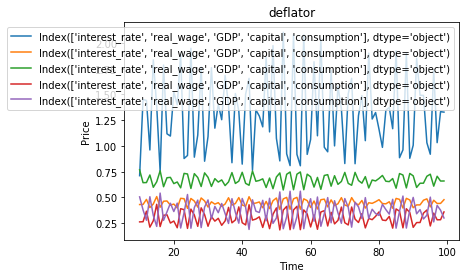

In [27]:
dataandfig(delta=.5,name="point5",t=100)

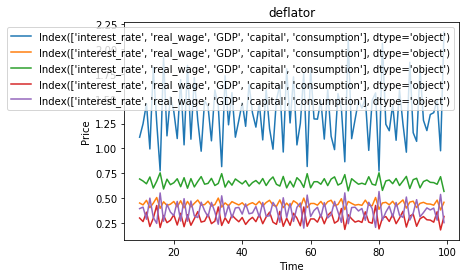

In [28]:
dataandfig(delta=0,name="zero",t=100)

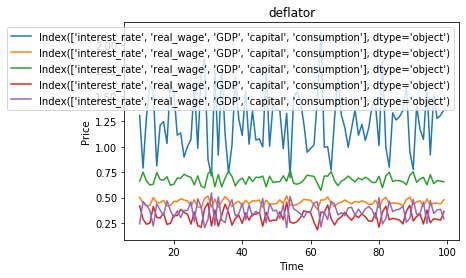

In [29]:
dataandfig(delta=.9,name="point9",t=100)

## next steps

variance in interest_rate:
    how does it vary with delta and H
    aggregate over runs

1) Run this code, tell us the outcome (commit to GitHub)

2) make a list of all variances and correlations of interest, modify this code to collect those


In [30]:
t=50

for thisH in np.linspace(0,10,11):
    for thisdelta in np.linspace(0,1,11):
        thesestats=[]
        for runs in range(100):
            dat=runmodel( delta=thisdelta , H=thisH, verbose=False,t=t)
            thisdat=dat[10:t]
            thesestats.append(statistics.variance(thisdat["interest_rate"]))
#            for col in thisdat.columns:
#                thesestats.append(statistics.variance(thisdat[col])
        avg_interestrate_var=statistics.mean(thesestats)
        print("delta", thisdelta, "H", thisH, ": ", avg_interestrate_var)

delta 0.0 H 0.0 :  0.09503678988231183
delta 0.1 H 0.0 :  0.0920980269483632
delta 0.2 H 0.0 :  0.09545365130969918
delta 0.30000000000000004 H 0.0 :  0.12256564438781649
delta 0.4 H 0.0 :  0.10946752197829404
delta 0.5 H 0.0 :  0.1601687209909156
delta 0.6000000000000001 H 0.0 :  0.23287212556312714
delta 0.7000000000000001 H 0.0 :  0.18536416952736073
delta 0.8 H 0.0 :  0.09939913793720563
delta 0.9 H 0.0 :  0.09202717489231922
delta 1.0 H 0.0 :  0.16164568071519972
delta 0.0 H 1.0 :  0.09723114824540544
delta 0.1 H 1.0 :  0.09184415104127498
delta 0.2 H 1.0 :  0.09496332617669657
delta 0.30000000000000004 H 1.0 :  0.12160242295201833
delta 0.4 H 1.0 :  0.10992206919670272
delta 0.5 H 1.0 :  0.16023229572207048
delta 0.6000000000000001 H 1.0 :  0.23618567761990036
delta 0.7000000000000001 H 1.0 :  0.18560103721238588
delta 0.8 H 1.0 :  0.10162612503889062
delta 0.9 H 1.0 :  0.09374082068723928
delta 1.0 H 1.0 :  0.18080908156103942
delta 0.0 H 2.0 :  0.09697554583045648
delta 0.1 H 2

In [63]:
print(np.linspace(0,1,11))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [76]:
statistics.mean(np.linspace(0,1,11))

0.5